On imagine ici un terrain 

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random


from ortools.sat.python import cp_model
import sys
import os
import matplotlib
import matplotlib.pyplot as plt



import uuid
import math
import json
import copy

from enum import Enum, unique

In [13]:
"""
#latitude, longitude
position = [45.820874, 5.404932]

#api key from https://solcast.com.au/solar-data-api/api/
api_key='yij5KTCUiTvBRHWsf89uNCXYG3QSpOGl'
    
r = requests.get('https://api.solcast.com.au/radiation/forecasts?latitude='+str(position[0])+'&longitude='+str(position[1])+'&api_key='+str(api_key)+'&format=json').text
data = json.loads(r)

print(json.dumps(data, indent=4))
"""

"\n#latitude, longitude\nposition = [45.820874, 5.404932]\n\n#api key from https://solcast.com.au/solar-data-api/api/\napi_key='yij5KTCUiTvBRHWsf89uNCXYG3QSpOGl'\n    \nr = requests.get('https://api.solcast.com.au/radiation/forecasts?latitude='+str(position[0])+'&longitude='+str(position[1])+'&api_key='+str(api_key)+'&format=json').text\ndata = json.loads(r)\n\nprint(json.dumps(data, indent=4))\n"

## Utils functions

In [14]:
def get_far_values(data, val, rg):
    """Retrieve the farthest values from a value and a max distance
    Args:
        data (list): list containing objects
        val (int): reference point
        rg (int): distance between reference point and all list's values
    Returns:
        list containing elements with ditance > rg
    """
    l = []
    for e in data:
        if abs(e.sunExposureTime - val) > rg:
            l.append(e)
    return l

## Utils elements

```
@unique
class SoilType(Enum):
    """Enum to represent most known soil type"""
    Azote = 1
    Humifere = 2
    ArgileuxLimoneux = 3
    Pauvre = 4
    Compact = 5
    Calcaire = 6 
```

In [15]:
class Box():
    
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        self.__name = name
        self.__pos_x = int(pos_x * 10)
        self.__pos_y = int(pos_y * 10)
        self.__dim_x = int(dim_x * 10)
        self.__dim_y = int(dim_y * 10)
        self.__color = str(color)
    
    @property
    def name(self):
        return self.__name
    
    @property
    def pos_x(self):
        return self.__pos_x
    
    @property
    def color(self):
        return self.__color
    
    @property
    def pos_y(self):
        return self.__pos_y
    
    @property
    def dim_x(self):
        return self.__dim_x
    
    @property
    def dim_y(self):
        return self.__dim_y
    
    @name.setter
    def name(self, value):
        self.__name = value
    
    @pos_x.setter
    def pos_x(self, value):
        self.__pos_x = value
    
    @pos_y.setter
    def pos_y(self, value):
        self.__pos_y = value
        
    @dim_x.setter
    def dim_x(self, value):
        self.__dim_x = value
        
    @dim_y.setter
    def dim_y(self, value):
        self.__dim_y = value
        
    @color.setter
    def color(self, color):
        self.__color = color
        
    def __str__(self):
        return 'name: {} \n pos_x: {} \n pos_y: {}'.format(self.name, self.pos_x, self.pos_y)
        
class BoxFixed(Box): 
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)

class BoxMovable(Box):
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)

In [16]:
class Plant(BoxMovable):
    """Set plant square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, sunExposureTime, soilTypeAvoided):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__sunExposureTime = sunExposureTime
        self.__soilTypeAvoided = soilTypeAvoided
    @property
    def sunExposureTime(self):
        return self.__sunExposureTime
    
    @property
    def soilTypeAvoided(self):
        return self.__soilTypeAvoided
          
    @sunExposureTime.setter
    def sunExposureTime(self, sunExposureTime):
        self.__sunExposureTime = sunExposureTime
        
    @soilTypeAvoided.setter
    def soilTypeAvoided(self, soilTypeAvoided):
        self.__soilTypeAvoided = soilTypeAvoided
        
class Sun(BoxFixed):
    """Set luminosity square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, sunExposureTime):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__sunExposureTime = sunExposureTime
    
    @property
    def sunExposureTime(self):
        return self.__sunExposureTime
    
    @sunExposureTime.setter
    def sunExposureTime(self, sunExposureTime):
        self.__sunExposureTime = sunExposureTime
        
class Soil(BoxFixed):
    """Set soil square in modelisation"""
    def __init__(self, name, pos_x, pos_y, dim_x, dim_y, color, soilType):
        super().__init__(name, pos_x, pos_y, dim_x, dim_y, color)
        self.__soilType = soilType
    
    @property
    def soilType(self):
        return self.__soilType
    
    @soilType.setter
    def soilType(self, soilType):
        self.__soilType = soilType


In [17]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variable_list, limit):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variable_list = variable_list
        self.__solution_count = 0
        self.__solution_limit = limit

    def on_solution_callback(self):
        self.__solution_count += 1
        fig = plt.figure()
        ax = fig.add_subplot(111)
        legend_list = []
        for shape in self.__variable_list:
            
            # Test obligatoire car si valeur fixe le modèle plante
            pos_x = self.Value(shape[0]) / 10.0 
            pos_y = self.Value(shape[1]) / 10.0 
            dim_x = self.Value(shape[2]) / 10.0 
            dim_y = self.Value(shape[3]) / 10.0
            color = shape[4]
            name = shape[5]
            
            if name != "light_sunlight" and name != "full_sunlight" and name != 'Humifere' and name != "ArgileuxLimoneux" and name != "Calcaire":
                print('name = %s' % name)
                print('pos_x = %f' % pos_x)
                print('pos_y = %f' % pos_y)
                print('dim_x = %f' % dim_x)
                print('dim_y = %f' % dim_y)
            
            alpha = 0.4
            if name == "s":
                alpha = 0.2
                
            rect = matplotlib.patches.Rectangle((pos_x, pos_y),
                                                dim_x, dim_y , color=color, alpha=alpha)
            
            ax.add_patch(rect)
            # TODO Clean or delete
            #ax.xaxis.set_ticks(range(TAILLE_W))
            #ax.yaxis.set_ticks(range(TAILLE_H))
            # Display in graph
            if name != "light_sunlight" and name != "full_sunlight" and name != 'Humifere' and name != "ArgileuxLimoneux" and name != "Calcaire":
                ax.text(pos_x + (dim_x / 2) , pos_y + (dim_y / 2) , name, fontsize=8, horizontalalignment='center',
                    verticalalignment='center')
            # Display in right legend
            else:
                if len(legend_list) == 0:
                    ax.scatter(pos_x, pos_y, c=color, s=None, label=name, alpha=alpha, edgecolors='none')
                    legend_list.append(name)
                else:
                    if name not in legend_list:
                        ax.scatter(pos_x, pos_y, c=color, s=None, label=name, alpha=alpha, edgecolors='none')
                        legend_list.append(name)
                        
        ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.xlim([0, TAILLE_W])
        plt.ylim([0, TAILLE_H])
        plt.gca().set_aspect('equal', adjustable='box')   
        plt.show()
        
        
        if self.__solution_count >= self.__solution_limit:
            print('Stop search after %i solutions' % self.__solution_limit)
            self.StopSearch()
        
    def solution_count(self):
        return self.__solution_count

In [18]:
def displayJSON(file):
    print(json.dumps(file, indent=4))


class plantBoxProblem():
    def __init__(self, box):
        # model initialisation
        self.__model = cp_model.CpModel()
        # solver creation
        self.__solver = cp_model.CpSolver()
        
        # init main box
        self.__box = box

        # init list of plants
        self.__elem_list = []
        
        #self.__json_file = path_json
        
    @property
    def box(self):
        return self.__box
    
    @property
    def model(self):
        return self.__model
    
    @property
    def solver(self):
        return self.__solver
    
    @property
    def elem_list(self):
        return self.__elem_list
    
    @property
    def json_file(self):
        return self.__json_file
    
    @box.setter
    def box(self, value):
        self.__box = value

    @model.setter
    def model(self, value):
        self.__model = value
    
    @solver.setter
    def solver(self, value):
        self.__solver = value
        
    @elem_list.setter
    def elem_list(self, value):
        self.__elem_list = value
              

    def boxes_distance(self, b1, b2, min_dist = 0, max_dist = 0):
        """ Allow to set a distance between 2 plants
        Args:
            b1 (Box): Box1 to place
            b2 (Box): Box2 to place
            min_dist (int): distance minimum between the 2 boxes
            max_dist (int): distance max between the 2 boxes

        Side effect:
            Add horizontal & vertical constraints with specific distance choosed
        Returns:
            None
        """  
        print("far condition beetween: %s and %s" % (str(b1.name), str(b2.name)))
        a = self.__model.NewBoolVar(str(uuid.uuid4()))
        b = self.__model.NewBoolVar(str(uuid.uuid4()))
        c = self.__model.NewBoolVar(str(uuid.uuid4()))
        d = self.__model.NewBoolVar(str(uuid.uuid4()))
        e = self.__model.NewBoolVar(str(uuid.uuid4()))
        f = self.__model.NewBoolVar(str(uuid.uuid4()))
        g = self.__model.NewBoolVar(str(uuid.uuid4()))
        h = self.__model.NewBoolVar(str(uuid.uuid4()))
        i = self.__model.NewBoolVar(str(uuid.uuid4()))
        j = self.__model.NewBoolVar(str(uuid.uuid4()))
        k = self.__model.NewBoolVar(str(uuid.uuid4()))
        l = self.__model.NewBoolVar(str(uuid.uuid4()))
        m = self.__model.NewBoolVar(str(uuid.uuid4()))
        n = self.__model.NewBoolVar(str(uuid.uuid4()))


        # Horizontal constraints
        self.__model.Add(b1.pos_x >= b2.pos_x + b2.dim_x + int(min_dist * 10)).OnlyEnforceIf(a)
        self.__model.Add(b1.pos_x <= b2.pos_x + b2.dim_x + int(max_dist * 10)).OnlyEnforceIf(b)
        
        
        self.__model.Add(b2.pos_x >= b1.pos_x + b1.dim_x + int(min_dist * 10)).OnlyEnforceIf(c)
        self.__model.Add(b2.pos_x <= b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(d)
        
        
        # Vertical constraints
        
        self.__model.Add(b1.pos_y >= b2.pos_y + b2.dim_y + int(min_dist * 10)).OnlyEnforceIf(e)
        self.__model.Add(b1.pos_y <= b2.pos_y + b2.dim_y + int(max_dist * 10)).OnlyEnforceIf(f)
        
        self.__model.Add(b2.pos_y >= b1.pos_y + b1.dim_y + int(min_dist * 10)).OnlyEnforceIf(g)
        self.__model.Add(b2.pos_y <= b1.pos_y + b1.dim_y + int(max_dist * 10)).OnlyEnforceIf(h)

        self.__model.AddBoolAnd([a, b, e, f]).OnlyEnforceIf(i)
        self.__model.AddBoolAnd([c, d, g, h]).OnlyEnforceIf(j)


        self.__model.AddBoolOr([i, j])

        # (redundant) constraints to help the solver to cut some branches
        
        self.__model.Add(b1.pos_x < b2.pos_x + b2.dim_x + int(min_dist * 10)).OnlyEnforceIf(a.Not())
        self.__model.Add(b1.pos_x > b2.pos_x + b2.dim_x + int(max_dist * 10)).OnlyEnforceIf(b.Not())
        

        self.__model.Add(b1.pos_y < b2.pos_y + b2.dim_y + int(min_dist * 10)).OnlyEnforceIf(e.Not())
        self.__model.Add(b1.pos_y > b2.pos_y + b2.dim_y + int(max_dist * 10)).OnlyEnforceIf(f.Not())
        

        self.__model.Add(b2.pos_x < b1.pos_x + b1.dim_x + int(min_dist * 10)).OnlyEnforceIf(c.Not())
        self.__model.Add(b2.pos_x > b1.pos_x + b1.dim_x + int(max_dist * 10)).OnlyEnforceIf(d.Not())

        
        self.__model.Add(b2.pos_y < b1.pos_y + b1.dim_y + int(min_dist * 10)).OnlyEnforceIf(g.Not())
        self.__model.Add(b2.pos_y > b1.pos_y + b1.dim_y + int(max_dist * 10)).OnlyEnforceIf(h.Not())

        
        # -(A ^ B) <=> (-A V -B) Morgan Law
        self.__model.AddBoolOr([a.Not(), b.Not(), e.Not(), f.Not()]).OnlyEnforceIf(i.Not())
        self.__model.AddBoolOr([c.Not(), d.Not(), g.Not(), h.Not()]).OnlyEnforceIf(j.Not())
        
      
    def plants_associations(self, b1, b2, data):     
        """ Retrieves the optimal distance between two plants
        Args:
            b1 (Plant): first plant 
            b2 (Plant): second plant
            data (Json file): json file containing plants data 
        Side effect:
            Set specific distance between 2 plants
        Returns:
            None
        """
        # TODO On a deux cas ici premier cas ou on a une distance
        self.boxes_distance(b1, b2, data[b1.name]["plantsCombinations"][b2.name]["distance"],data[b1.name]["plantsCombinations"][b2.name]["distance"])

        # TODO Sinon on a une distance par défaut
        
    def plants_luminosity(self, plant, data):
        """ Set no_overlap constraints with squares having farthest sunExposure values.
        Args:
            plant (Plant): reference plant. 
            data (Json file): json file containing sun infos. 
        Side effect:
            set no_overlap constraints in model.
        Returns:
            None
        """
        luminosity_squares = get_far_values(data, plant.sunExposureTime, 4)
        for item in luminosity_squares:
            self.no_overlap(plant, item)
    
    def plants_soil(self, plant, data):
        for item in data:
            if item.soilType in plant.soilTypeAvoided:
                print("plante : {} \n item: {} ".format(plant.name, item.name))
                self.no_overlap(plant, item)
            
    def check_orientation(self, plant):
        half_h = int(TAILLE_H / 2) * 10
        half_w = int(TAILLE_W / 2) * 10
        
        if plant.orientation != "None":
            for orien in plant.orientation:   
                if orien == "N":
                    self.__model.Add(((plant.pos_y + plant.dim_y) - plant.dim_y) > half_h)
                if orien == "S":
                    self.__model.Add(((plant.pos_y + plant.dim_y) - plant.dim_y) < half_h)
                if orien == "E": 
                    self.__model.Add(((plant.pos_x + plant.dim_x) - plant.dim_x) > half_w)
                if orien == "W": 
                    self.__model.Add(((plant.pos_x + plant.dim_x) - plant.dim_x) < half_w)
        
        
    def check_inside(self, b1, b2):
        """ Make sure one block goes into another
        Args:
            b1 (Box): first box to fit in b2. 
            b2 (Box): second box containing b1. 
        Side effect:
            set fit constraint b1 in b2
        Returns:
            None
        """
        self.__model.Add(b1.pos_x >= b2.pos_x)
        self.__model.Add(b1.pos_y >= b2.pos_y)
        self.__model.Add(b1.pos_x + b1.dim_x <= b2.pos_x + b2.dim_x)
        self.__model.Add(b1.pos_y + b1.dim_y <= b2.pos_y + b2.dim_y)
    
    def no_overlap(self, b1, b2):
        """ Set constraints 2 boxes don't overlap each other
        Args: 
            b1 (Box): first box
            b2 (Box): second box
        Side effect:
           set no_overlap constraints in model.
        Returns:
            None
        """
        a = self.__model.NewBoolVar(str(uuid.uuid4()))
        b = self.__model.NewBoolVar(str(uuid.uuid4()))
        c = self.__model.NewBoolVar(str(uuid.uuid4()))
        d = self.__model.NewBoolVar(str(uuid.uuid4()))
        
        self.__model.Add(b1.pos_x + b1.dim_x <= b2.pos_x).OnlyEnforceIf(a)
        self.__model.Add(b2.pos_x + b2.dim_x <= b1.pos_x).OnlyEnforceIf(b)
        self.__model.Add(b1.pos_y + b1.dim_y <= b2.pos_y).OnlyEnforceIf(c)
        self.__model.Add(b2.pos_y + b2.dim_y <= b1.pos_y).OnlyEnforceIf(d)
        
        # (redundant) constraints to help the solver to cut some branches
        self.__model.Add(b1.pos_x + b1.dim_x > b2.pos_x).OnlyEnforceIf(a.Not())
        self.__model.Add(b2.pos_x + b2.dim_x > b1.pos_x).OnlyEnforceIf(b.Not())
        self.__model.Add(b1.pos_y + b1.dim_y > b2.pos_y).OnlyEnforceIf(c.Not())
        self.__model.Add(b2.pos_y + b2.dim_y > b1.pos_y).OnlyEnforceIf(d.Not())
        
        self.__model.AddBoolOr([a,b,c,d])
        
    def add_box(self, box):
        """ Adding a box in model
        
        Args: 
            box (Box): box to add in model
        Side effect:
            Set domain variables for pos_x, pos_y, dim_x, dim_y 
        Returns:
            None
        """
        # If we can move the box 
        if isinstance(box, BoxMovable):
            box.pos_x = self.__model.NewIntVar(0, self.__box.dim_x, 'b%i_pos_x' % len(self.__elem_list))    
            box.pos_y = self.__model.NewIntVar(0, self.__box.dim_y, 'b%i_pos_y' % len(self.__elem_list))

            # if we have a square
            if box.dim_x == box.dim_y:
                box.dim_x = self.__model.NewIntVar(box.dim_x, box.dim_x, 'b%i_dim_x' % len(self.__elem_list))  
                box.dim_y = self.__model.NewIntVar(box.dim_y, box.dim_y, 'b%i_dim_y' % len(self.__elem_list))
            else:
                # TODO b = plant is not super efficient maybe call makeInVar constructor with int ??
                b = box
                if box.dim_x < box.dim_y:
                    x = self.__model.NewEnumeratedIntVar([b.dim_x, b.dim_x, b.dim_y, b.dim_y], 'b%i_dim_x' % len(self.__elem_list))
                    y = self.__model.NewEnumeratedIntVar([b.dim_x, b.dim_x, b.dim_y, b.dim_y], 'b%i_dim_y' % len(self.__elem_list))
                    b.dim_x = x
                    b.dim_y = y
                else:
                    x = self.__model.NewEnumeratedIntVar([b.dim_y, b.dim_y, b.dim_x, b.dim_x ], 'b%i_dim_x' % len(self.__elem_list))
                    y = self.__model.NewEnumeratedIntVar([b.dim_y, b.dim_y, b.dim_x, b.dim_x], 'b%i_dim_y' % len(self.__elem_list))
                    b.dim_x = x
                    b.dim_y = y
                # This constraint allows rotation to 90°
                self.__model.Add(b.dim_x != b.dim_y) 
        else: 
            box.pos_x = self.__model.NewIntVar(box.pos_x, box.pos_x, 'b%i_pos_x' % len(self.__elem_list))    
            box.pos_y = self.__model.NewIntVar(box.pos_y, box.pos_y, 'b%i_pos_y' % len(self.__elem_list))
            box.dim_x = self.__model.NewIntVar(box.dim_x, box.dim_x, 'b%i_dim_x' % len(self.__elem_list))  
            box.dim_y = self.__model.NewIntVar(box.dim_y, box.dim_y, 'b%i_dim_y' % len(self.__elem_list))
 
        self.check_inside(box, self.__box)
        self.__elem_list.append(box)
   

    def solve(self):
        l = []
        for elem in self.__elem_list:
            sub_list = []
            sub_list.append(elem.pos_x)
            sub_list.append(elem.pos_y)
            sub_list.append(elem.dim_x)
            sub_list.append(elem.dim_y)
            sub_list.append(elem.color)
            sub_list.append(elem.name)
            #sub_list.append(elem.orientation)
            l.append(sub_list)
      
        solution_printer = VarArraySolutionPrinter(l, 1000)
        status = self.__solver.SearchForAllSolutions(self.__model, solution_printer)

        print('Status = %s' % self.__solver.StatusName(status))
        print('Number of solutions found: %i' % solution_printer.solution_count())

In [19]:
# file path for plants associations
plants_json = './data_model/plant-associations.json'

# file path for map, compraining soil square and sun light square
maps_json = './data_model/maps.json'

with open(plants_json, 'r') as f:
    data_plants = json.load(f)
    

with open(maps_json, 'r') as f:
    data_maps = json.load(f)
    # Choose a random number
    #data_maps = data_maps[random.randint(0,2)]
    data_maps = data_maps[0]


    
TAILLE_W = data_maps["dimensions"]['TAILLE_W']
TAILLE_H = data_maps["dimensions"]['TAILLE_H']

    
listOfPlants = []    
luminosity_squares = []
soil_squares = []
path = []

print(data_plants["Carotte"]["plantsCombinations"]["Ail"]["distance"])

1


## User Interface
Pemamind's minimalist interface functions

In [20]:
def modify_user_string(string):
    string_format = ""
    for c in range(len(string)):
        if c == 0:
            string_format += str(string[c]).upper()
        else:
            string_format += str(string[c]).lower() 
    return string_format
    

def quantityComputation(qt):
    # Bout de code fais rapidement
    if qt < 5:
        loop_count = 1
        if qt > 0 and qt < 3:
            dimX = 1
            dimY = 2
        elif qt >= 3 and qt < 5:
            dimX = 2
            dimY = 2
            # Or dimY = 2 / dimX = 1
        else:
            dimX = 3
            dimY = 3
    elif qt >= 5 and qt < 10:
        loop_count = 2
        if qt >= 5 and qt <= 7:
            dimX = 3
            dimY = 4
        elif qt > 7 and qt < 9:
            dimX = 2
            dimY = 4
        else:
            dimX = 3
            dimY = 5
    else:
        loop_count = 3
        dimX = 4
        dimY = 5
        
    return loop_count, dimX, dimY


def insertPlantsWithQuantity(listOfPlants, plant_name, qt):
    loop_count, dimX, dimY = quantityComputation(int(qt))
    for i in range(loop_count):
        listOfPlants.append(Plant(plant_name, 0, 0, dimX, dimY, data_plants[plant_name]["color"], data_plants[plant_name]["sunExposureTimeInHour"], data_plants[plant_name]["soilTypeAvoided"]))
    return listOfPlants

def displayListOfPlants(l):
    print([[x.name,l.count(x)] for x in set(l)])
    
        

def loadPlantsDebug():
    """
    l = [Plant("Carotte", 0, 0, 1, 2, "orange", 6, [
                                    "Calcaire",
                                    "Azote",
                                    "Pauvre",
                                    "Compact"
                                  ]),
         Plant("Poireau", 0, 0, 1, 2, "green", 13, [
                                      "Calcaire",
                                      "Azote",
                                      "Pauvre",
                                      "Compact"
                                    ]),
          Plant("Ail", 0, 0, 1, 2, "pink", 3, [
                                  "Humifere",
                                  "Azote",
                                  "Pauvre",
                                  "Compact"
                                ])]
    """
    
    l = [ Plant("Poireau", 0, 0, 0.2, 2, "green", 13, [
                                      "Calcaire",
                                      "Azote",
                                      "Pauvre",
                                      "Compact",
                                      "ArgileuxLimoneux"
                                    ]),  Plant("Poireau", 0, 0, 0.5, 0.3, "green", 13, [
                                      "Calcaire",
                                      "Azote",
                                      "Pauvre",
                                      "Compact",
                                      "ArgileuxLimoneux"
                                    ])]
    for item in l:
        listOfPlants.append(item)
    
    garden = BoxFixed('Box', 0, 0, TAILLE_W, TAILLE_H, "white")
    block_problem = create_model(garden, listOfPlants)
    block_problem.solve()
    print('Statistics')
    print('  - conflicts       : %i' % block_problem.solver.NumConflicts())
    print('  - branches        : %i' % block_problem.solver.NumBranches())
    print('  - wall time       : %f s' % block_problem.solver.WallTime())

    
def askUserModifyChoice(listOfPlants):
    print("\nAie Aie ...")
    print("Ton choix cher petit jardinier me semble difficile à satisfaire :( ")
    print("- Voici les plantes que tu désires ajouter")
 
    # TODO faire une function qui fais la liste bien présentée
    displayListOfPlants(listOfPlants)
    
    present = False
    while True:
        print("- Pourrions nous réduire la quantité d'une plante afin de satisfaire le modèle ?")
        answer = input()
        answer = modify_user_string(answer)
        if answer == "Oui":
            print("- Quelle plante ?")
            plant = True
            while type(plant) is not str:
                plant = input()
            plant = modify_user_string(plant)
            for e in listOfPlants:
                if e.name == plant:
                    while True:
                        print("Veux tu supprimer cette plante ou réduire sa quantité ?")
                        print("'Supprimer' ou 'Reduire' :)")
                        answ = input()
                        answ = modify_user_string(answ)
                        if answ == "Supprimer":
                            listOfPlants = [x for x in listOfPlants if plant not in x.name]
                            present = True
                            break
                        if answ == "Reduire":
                            listOfPlants = [x for x in listOfPlants if plant not in x.name]
                            print("Quelle est la nouvelle quantité pour {}".format(plant))
                            qt = input()
                            listOfPlants = insertPlantsWithQuantity(listOfPlants, plant, qt)
                            present = True
                            break
                    break
        elif answer == "Non":
            raise Exception("L'utilisateur ne veut pas changer son choix /!\ En construction /!\ ")
                    
        if present:
            print("Liste mise à jour ...")
            return listOfPlants
        else:
            print("Element non présent dans votre liste")
        
        
def welcome():
    print("             Bonjour petit paysan débutant ! \n                 Bienvenue sur Permamind !\n\n")
    print("- Pourrais tu me fournir les données du terrain que tu désires aménager s'il te plait ?")
    print("    ... /!\ En construction /!\ Récupération JSON simulant les données du terrain ...")    
    print("    Je vais te fournir les espèces de légumes bien adapté à ton terrain.")

def askUserAndAdjust(listOfPlants):
    welcome()
    while True:
        print("- Fais ta sélection parmis la liste proposée !")
        for e in data_plants:
            print("   *", e)
        plant = True
        while type(plant) is not str:
            plant = input()
        plant = modify_user_string(plant)
        if plant in data_plants:
            print("- Tu as choisi {}".format(plant))
            print("    Quelle quantité de {} desires tu ?".format(str(plant)))
            qt = input()
            print("- Tu as choisi de planter {} {}(s)".format(qt, str(plant)))
            
            listOfPlants = insertPlantsWithQuantity(listOfPlants, plant, qt)
            
            while True:
                listOfElem = copy.deepcopy(listOfPlants)                                                                                                         
                garden = BoxFixed('Box', 0, 0, TAILLE_W, TAILLE_H, "white")
                block_problem = create_model(garden, listOfElem)

                status = block_problem.solver.Solve(block_problem.model)
                if status == cp_model.FEASIBLE:
                    print("- Desires tu continuer ?")
                    choice = input()
                    choice = modify_user_string(choice)
                    if choice == "Non":
                        return block_problem, listOfPlants
                    else:
                        break
                else:
                    listOfPlants = askUserModifyChoice(listOfPlants)

        else:
            print("Ce que tu as choisi n'est pas dans la base.")
        
        # TDOO Fonction qui fais la liste des plantes intégrées ...
    

In [21]:
def create_model(name, listOfElem):

    block_problem = plantBoxProblem(name)
        
    #for e in data_maps["sunlight_squares"]:
    #    sun = Sun(e["category"], e["pos_x"], e["pos_y"], e["dim_x"], e["dim_y"], e["color"], e["sunExposureTimeInHour"])
     #   luminosity_squares.append(sun)
     #   block_problem.add_box(sun)

    # Add soil squares to model
    for e in data_maps["soil_squares"]:
        soil = Soil(e["category"],e["pos_x"], e["pos_y"], e["dim_x"], e["dim_y"], e["color"], e["category"])
        soil_squares.append(soil)
        block_problem.add_box(soil)

    for p in listOfElem:
        block_problem.add_box(p)
        
    while len(listOfElem) != 0:    
        block_problem.plants_luminosity(listOfElem[0], luminosity_squares)
        block_problem.plants_soil(listOfElem[0], soil_squares)
        #block_problem.no_overlap(listOfPlants[0], path[0]) 
        for index, value in enumerate(listOfElem):
            if index != 0:
                block_problem.no_overlap(listOfElem[0], listOfElem[index]) 
                block_problem.plants_associations(listOfElem[0], listOfElem[index], data_plants)
        listOfElem.pop(0)
        
    return block_problem

        
def problem_resolution():
    
    loadPlantsDebug()
    #block_problem, new_listOfPlants = askUserAndAdjust(listOfPlants)
    #if len(new_listOfPlants) < 1:
     #   print("Nothing in my list. Need to treat this case before in the code")
    #else:
    #    block_problem.solve()
        # Statistics.
    #    print()
    #    print('Statistics')
    #    print('  - conflicts       : %i' % block_problem.solver.NumConflicts())
    #    print('  - branches        : %i' % block_problem.solver.NumBranches())
    #    print('  - wall time       : %f s' % block_problem.solver.WallTime())
    

# http://socialcompare.com/fr/comparison/association-de-legumes-au-jardin-potager-bio

plante : Poireau 
 item: ArgileuxLimoneux 
plante : Poireau 
 item: Calcaire 
plante : Poireau 
 item: Calcaire 
far condition beetween: Poireau and Poireau
plante : Poireau 
 item: ArgileuxLimoneux 
plante : Poireau 
 item: Calcaire 
plante : Poireau 
 item: Calcaire 
name = Poireau
pos_x = 5.400000
pos_y = 5.800000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.800000
pos_y = 4.000000
dim_x = 0.300000
dim_y = 0.500000


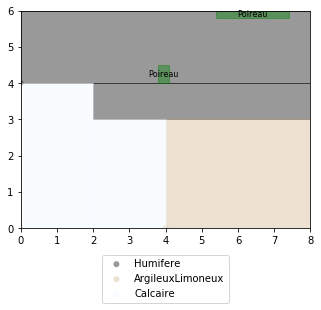

name = Poireau
pos_x = 5.500000
pos_y = 5.800000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 4.000000
dim_x = 0.300000
dim_y = 0.500000


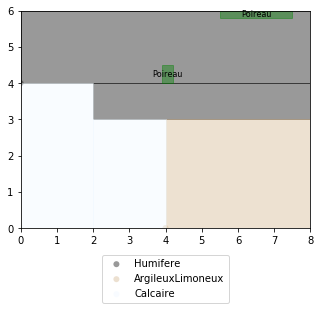

name = Poireau
pos_x = 5.500000
pos_y = 5.800000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 4.000000
dim_x = 0.300000
dim_y = 0.500000


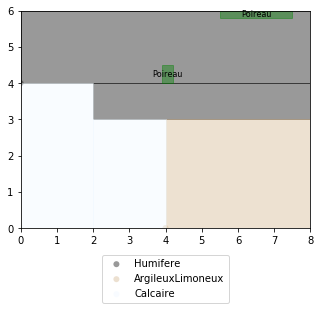

name = Poireau
pos_x = 5.500000
pos_y = 5.800000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 4.000000
dim_x = 0.300000
dim_y = 0.500000


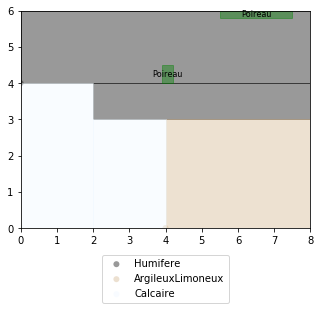

name = Poireau
pos_x = 5.500000
pos_y = 4.800000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.000000
dim_x = 0.300000
dim_y = 0.500000


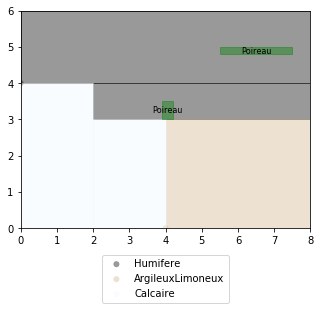

name = Poireau
pos_x = 5.500000
pos_y = 4.900000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.100000
dim_x = 0.300000
dim_y = 0.500000


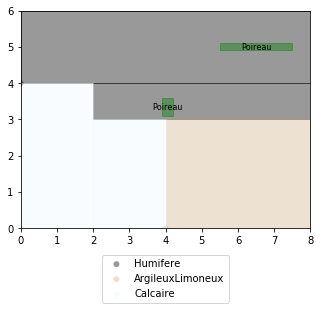

name = Poireau
pos_x = 5.500000
pos_y = 5.000000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.200000
dim_x = 0.300000
dim_y = 0.500000


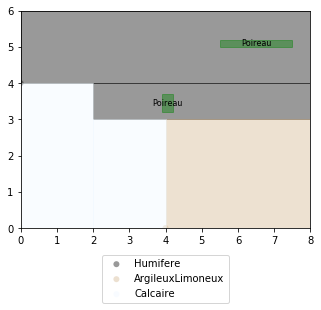

name = Poireau
pos_x = 5.500000
pos_y = 5.100000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.300000
dim_x = 0.300000
dim_y = 0.500000


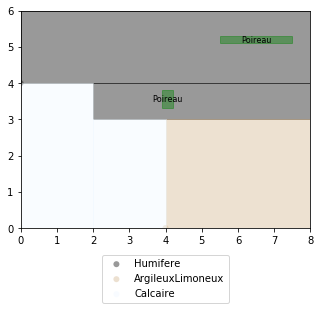

name = Poireau
pos_x = 5.500000
pos_y = 5.200000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.400000
dim_x = 0.300000
dim_y = 0.500000


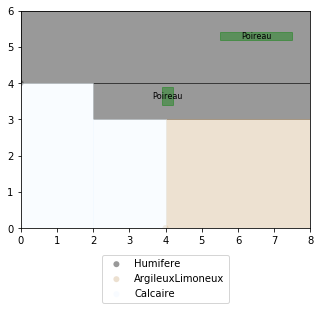

name = Poireau
pos_x = 5.500000
pos_y = 5.300000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.500000
dim_x = 0.300000
dim_y = 0.500000


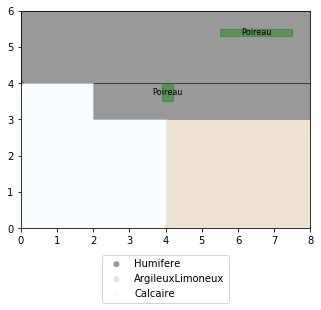

name = Poireau
pos_x = 5.500000
pos_y = 5.400000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.600000
dim_x = 0.300000
dim_y = 0.500000


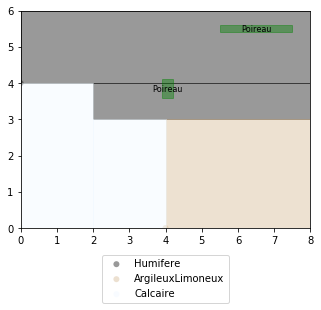

name = Poireau
pos_x = 5.500000
pos_y = 5.500000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.700000
dim_x = 0.300000
dim_y = 0.500000


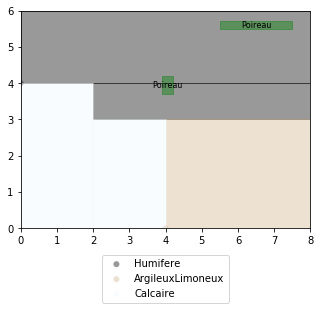

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


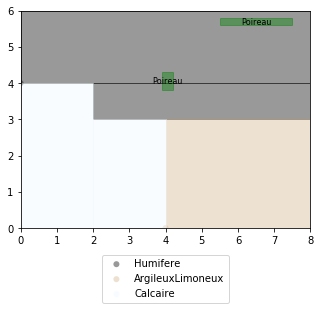

name = Poireau
pos_x = 5.500000
pos_y = 5.700000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.900000
dim_x = 0.300000
dim_y = 0.500000


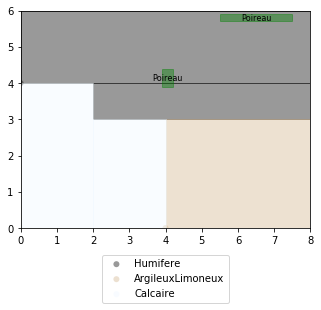

name = Poireau
pos_x = 5.500000
pos_y = 5.700000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.900000
dim_x = 0.300000
dim_y = 0.500000


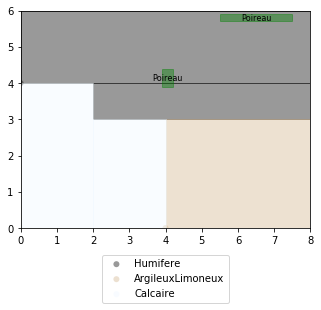

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


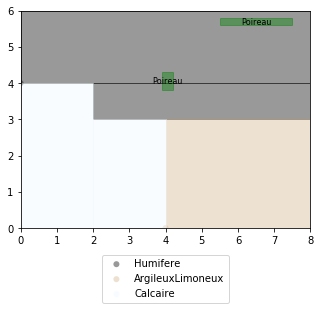

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


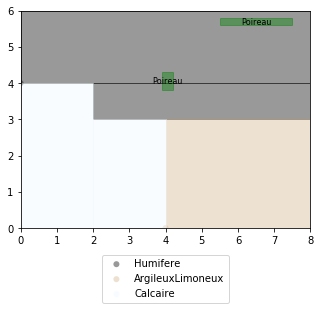

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


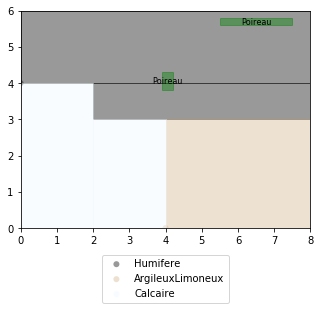

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


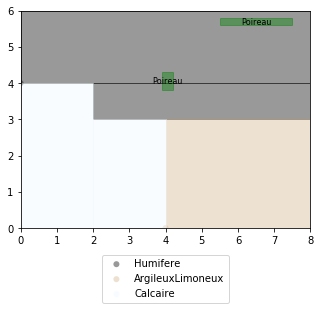

name = Poireau
pos_x = 5.500000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.900000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


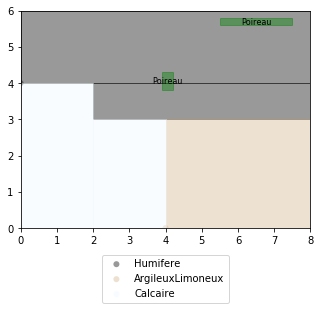

name = Poireau
pos_x = 5.600000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 4.000000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


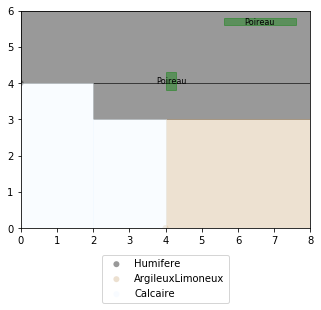

name = Poireau
pos_x = 5.700000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 4.100000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


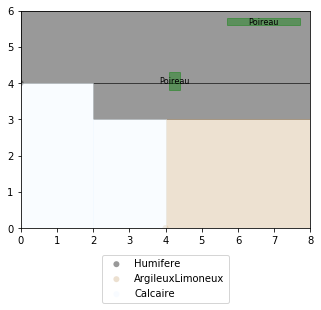

name = Poireau
pos_x = 5.800000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 4.200000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


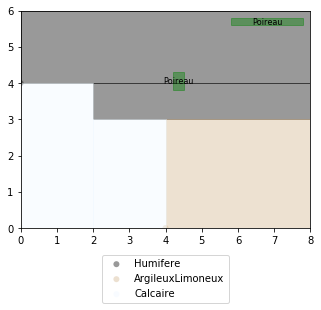

name = Poireau
pos_x = 5.900000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 4.300000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


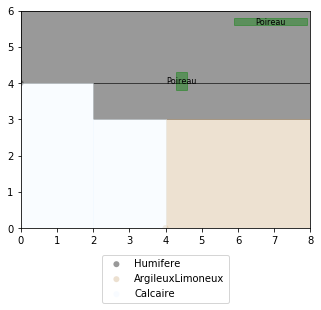

name = Poireau
pos_x = 6.000000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 4.400000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


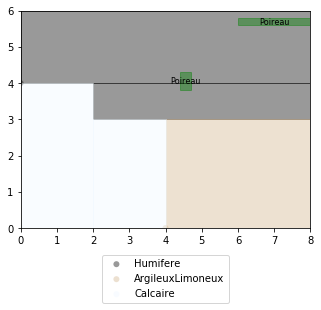

name = Poireau
pos_x = 5.400000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.800000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


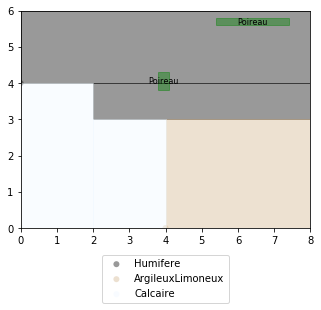

name = Poireau
pos_x = 5.400000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.800000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


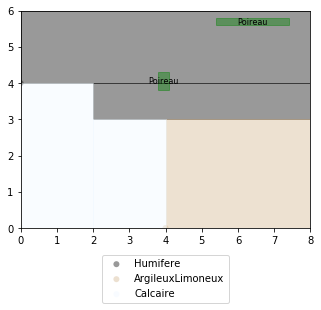

name = Poireau
pos_x = 5.400000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.800000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


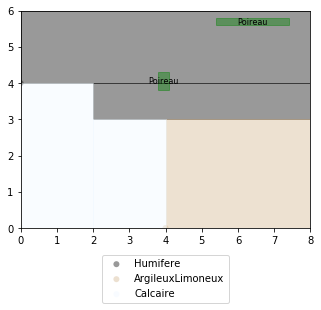

name = Poireau
pos_x = 5.400000
pos_y = 5.600000
dim_x = 2.000000
dim_y = 0.200000
name = Poireau
pos_x = 3.800000
pos_y = 3.800000
dim_x = 0.300000
dim_y = 0.500000


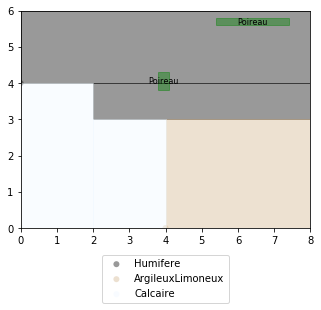

Status = FEASIBLE
Number of solutions found: 29
Statistics
  - conflicts       : 0
  - branches        : 318
  - wall time       : 4.609608 s


In [22]:
problem_resolution()